In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [27]:
import random
import networkx as nx

def fast_connected_gnm(n, m, directed=False):
    if directed:
        raise ValueError("Directed connected G(n,m) is not well-defined for weak connectivity.")

    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Step 1: random spanning tree (ensures connectivity)
    nodes = list(range(n))
    random.shuffle(nodes)
    for i in range(n-1):
        G.add_edge(nodes[i], nodes[i+1])

    # Step 2: add random edges until reaching m total edges
    needed = m - (n - 1)

    while G.number_of_edges() < m:
        u = random.randint(0, n-1)
        v = random.randint(0, n-1)
        if u != v and not G.has_edge(u, v):
            G.add_edge(u, v)

    return G

G = fast_connected_gnm(4783, 11140)


In [28]:
print(G)

Graph with 4783 nodes and 11140 edges


In [3]:
G = nx.gnm_random_graph(4783, 11140, seed=42,directed=True)

In [6]:
G.number_of_nodes()

4783

In [7]:
def random_closure_track(graph, threshold=0.5):
    G = graph.copy()
    edgelist = list(G.edges())
    N = G.number_of_nodes()
    
    edge_removed_list = []
    gc_history = []      # <-- record giant component size
    iter = 0

    components = list(nx.weakly_connected_components(G))
    current_gc_size = max(len(c) for c in components)
    gc_history.append(current_gc_size / N)   # record initial ratio

    while current_gc_size >= threshold * N:
        edge_index = np.random.randint(len(edgelist))
        edge = edgelist.pop(edge_index)
        G.remove_edge(*edge)
        edge_removed_list.append(edge)
        iter += 1
        
        components = list(nx.weakly_connected_components(G))
        current_gc_size = max(len(c) for c in components)
        
        gc_history.append(current_gc_size / N)   # record updated ratio

    return iter, edge_removed_list, G, gc_history
G_copy = G.copy()

In [8]:
iters, removed_edges, graph, gc_hist = random_closure_track(G_copy)

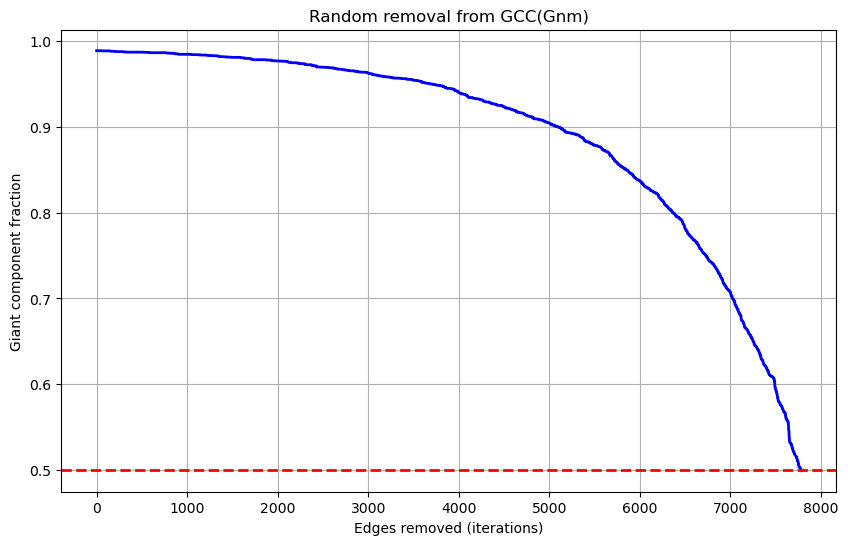

In [10]:
plt.figure(figsize=(10,6))
plt.plot(gc_hist, linewidth=2, color="Blue", label="Giant Component Fraction")
plt.axhline(0.5, linestyle="--", linewidth=2, color="Red", label="Threshold")   # threshold line

plt.xlabel("Edges removed (iterations)")
plt.ylabel("Giant component fraction")
plt.title("Random removal from GCC(Gnm)")
plt.grid(True)
plt.show()

In [15]:
import networkx as nx
import itertools
from multiprocessing import Pool
import math # Added for a potentially cleaner way to calculate chunk size

def chunks(l, n):
    l_c = iter(l)
    while True:
        x = tuple(itertools.islice(l_c, n))
        
        # Corrected indentation and logic: check if the slice is empty
        if not x:
            return 
        
        yield x

def betweenness_centrality_parallel_edge(G, processes=None):
    # 1. Initialize the Pool
    p = Pool(processes=processes)
    
    # Use the actual number of processes available in the Pool
    num_processes = len(p._pool) 
    
    # 2. Divide nodes into chunks
    chunk_size = math.ceil(G.order() / num_processes) 
    node_chunks = list(chunks(G.nodes(), chunk_size))
    num_chunks = len(node_chunks)

    # 3. Parallel calculation
    # Uses nx.edge_betweenness_centrality_subset to calculate partial edge centrality
    bt_sc = p.starmap(
        nx.edge_betweenness_centrality_subset,
        zip(
            [G] * num_chunks,        # G: The graph
            node_chunks,             # sources: The chunk of nodes
            [list(G)] * num_chunks,  # targets: All nodes
            [True] * num_chunks,     # normalized: True
            ["Length"] * num_chunks, # weight: The edge attribute to use for shortest paths
        ),
    )
    
    # 4. Terminate the Pool
    p.close()
    p.join()

    #
    # Start with the first result
    bt_e = bt_sc[0]
    
    # Sum the remaining results
    for bt in bt_sc[1:]:
        for edge, centrality in bt.items():
            # Since edges in a directed graph are unique (u, v) != (v, u), 
            # we just sum the centralities for the edge tuple.
            bt_e[edge] += centrality
            
    return bt_e



def strategic_closure_betweenness_efficient_parallel(graph, threshold=0.5, processes = None):
    G = graph.copy()
    N = G.number_of_nodes()

    gc_hist = []
    iterations = 0

    # initial GC size
    components = list(nx.weakly_connected_components(G))
    current_gc = max(len(c) for c in components)
    gc_hist.append(current_gc / N)

    while current_gc >= threshold * N:
        bw = betweenness_centrality_parallel_edge(G, processes=processes)

        edge_to_remove = max(bw, key=bw.get)
        G.remove_edge(*edge_to_remove)
        iterations += 1

        components = list(nx.weakly_connected_components(G))
        current_gc = max(len(c) for c in components)
        gc_hist.append(current_gc / N)

    return iterations, G, gc_hist


In [ ]:
G_copy = G.copy()
iter, G_re, gc_hist = strategic_closure_betweenness_efficient_parallel(G_copy, processes=4)

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(gc_hist, linewidth=2, label="Giant Component Fraction")
plt.axhline(0.5, linestyle="--", linewidth=2, label="Threshold = 0.5", color="Red")

plt.xlabel("Edges removed (iterations)")
plt.ylabel("Giant component fraction")
plt.title("Strategic Edge Removal (Betweenness Centrality)")
plt.grid(True)
plt.legend()
plt.show()